In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.ensemble import GradientBoostingClassifier,BaggingClassifier,AdaBoostClassifier,RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier,DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV
from sklearn.feature_selection import chi2,SelectKBest
from sklearn.pipeline import make_pipeline
from scipy.stats import wilcoxon


from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=14,16

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer

In [0]:
from sklearn.preprocessing import RobustScaler

In [0]:
train = pd.read_excel("Data_Train.xlsx")
test = pd.read_excel("Data_Test.xlsx")

In [0]:
train.head()

,ID,Date,LicenseNo,FacilityID,FacilityName,Type,Street,City,State,LocationID,Reason,SectionViolations,RiskLevel,Geo_Loc,Inspection_Results
0,31103489027986,26-04-2010,4744,8123,7715,RESTAURANT,15522,id-11235901,id_1890134,81876.0,CANVASS,33.0,High,locid16406,4
1,10088999935915,21-06-2009,2973,12268,11664,GROCERY STORE,3057,id-11235901,id_1890134,81862.0,COMPLAINT,33.0,High,locid878,4
2,40148966010272,01-05-2013,18223,1112,969,RESTAURANT,14988,id-11235901,id_1890134,81883.0,CANVASS,NaN,High,locid3368,6
3,37157708563676,28-09-2015,20825,20007,19115,RESTAURANT,3661,id-11235901,id_1890134,81859.0,CANVASS RE-INSPECTION,31.0,Medium,locid11839,4
4,47478049564374,09-12-2015,2136,16867,10409,RESTAURANT,7876,id-11235901,id_1890134,81886.0,COMPLAINT,30.0,High,locid12264,4


In [0]:
train.shape

(147443, 15)

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147443 entries, 0 to 147442
Data columns (total 15 columns):
ID                    147443 non-null int64
Date                  147443 non-null object
LicenseNo             147443 non-null int64
FacilityID            147443 non-null int64
FacilityName          147443 non-null int64
Type                  143958 non-null object
Street                147443 non-null int64
City                  147443 non-null object
State                 147443 non-null object
LocationID            147408 non-null float64
Reason                147443 non-null object
SectionViolations     108375 non-null float64
RiskLevel             147443 non-null object
Geo_Loc               147443 non-null object
Inspection_Results    147443 non-null int64
dtypes: float64(2), int64(6), object(7)
memory usage: 16.9+ MB


In [0]:
train.isnull().sum()

ID                        0
Date                      0
LicenseNo                 0
FacilityID                0
FacilityName              0
Type                   3485
Street                    0
City                      0
State                     0
LocationID               35
Reason                    0
SectionViolations     39068
RiskLevel                 0
Geo_Loc                   0
Inspection_Results        0
dtype: int64

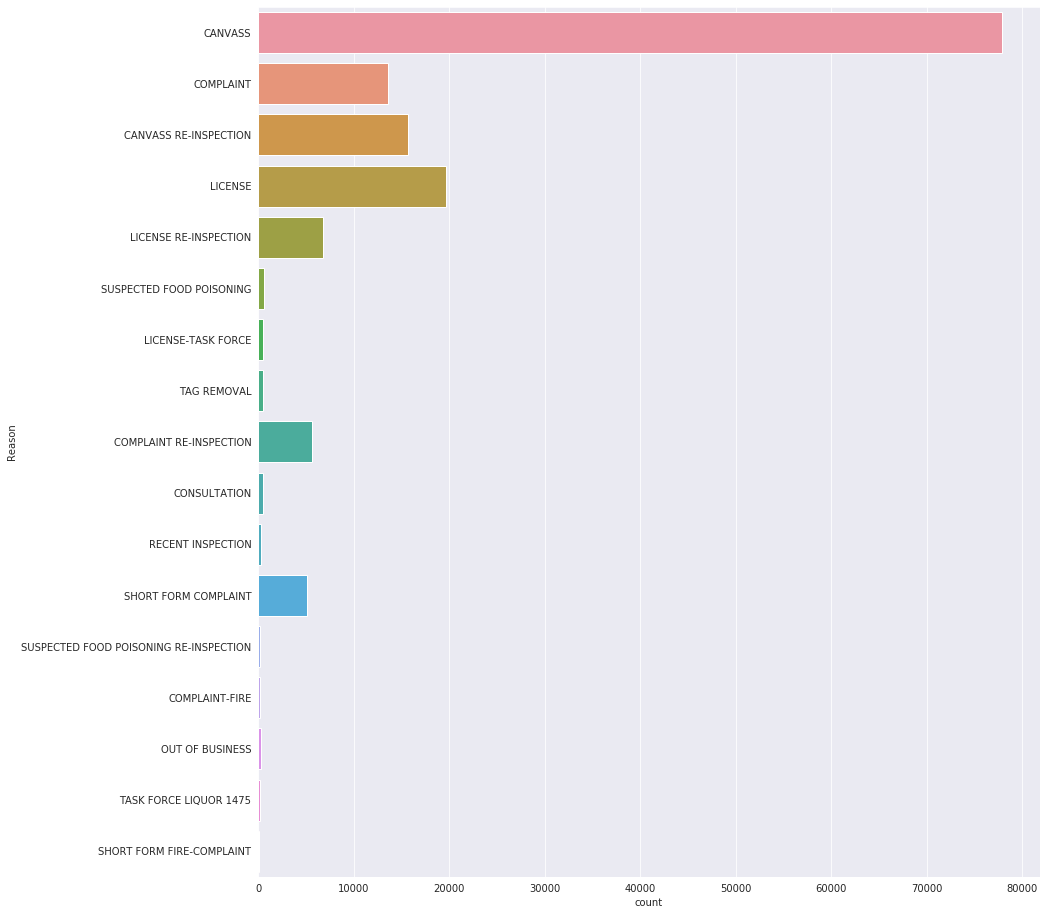

In [0]:
sns.countplot(y="Reason",data=train)

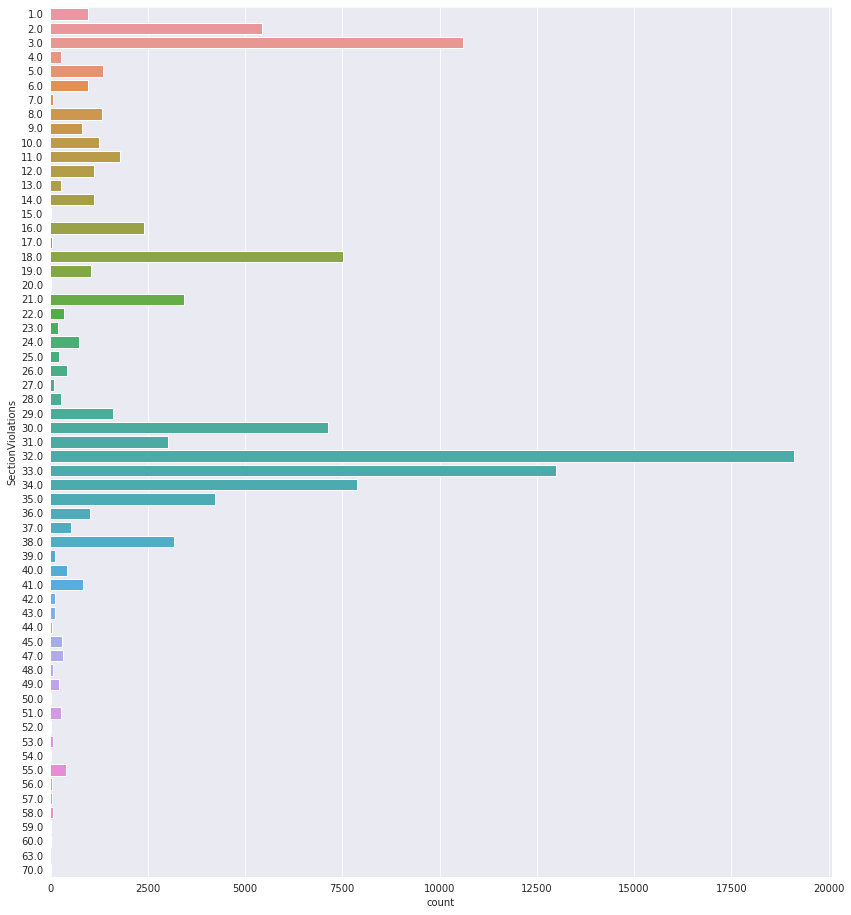

In [0]:
sns.countplot(y="SectionViolations",data=train)

In [0]:
train["Type"].value_counts().sort_values(ascending=False)

RESTAURANT                                 98346
GROCERY STORE                              18811
SCHOOL                                      9140
CHILDREN'S SERVICES FACILITY                2320
BAKERY                                      2212
                                           ...  
FROZEN DESSERTS DISPENSER-NON-MOTORIZED        1
HERBALIFE STORE                                1
CATERED EVENTS                                 1
FOOD VENDING MACHINES                          1
SERVICE BAR/THEATRE                            1
Name: Type, Length: 409, dtype: int64

In [0]:
train[train["SectionViolations"].notnull()]

,ID,Date,LicenseNo,FacilityID,FacilityName,Type,Street,City,State,LocationID,Reason,SectionViolations,RiskLevel,Geo_Loc,Inspection_Results
0,31103489027986,26-04-2010,4744,8123,7715,RESTAURANT,15522,id-11235901,id_1890134,81876.0,CANVASS,33.0,High,locid16406,4
1,10088999935915,21-06-2009,2973,12268,11664,GROCERY STORE,3057,id-11235901,id_1890134,81862.0,COMPLAINT,33.0,High,locid878,4
3,37157708563676,28-09-2015,20825,20007,19115,RESTAURANT,3661,id-11235901,id_1890134,81859.0,CANVASS RE-INSPECTION,31.0,Medium,locid11839,4
4,47478049564374,09-12-2015,2136,16867,10409,RESTAURANT,7876,id-11235901,id_1890134,81886.0,COMPLAINT,30.0,High,locid12264,4
5,25234292966802,07-02-2016,13009,7942,7547,RESTAURANT,12275,id-11235901,id_1890134,81877.0,CANVASS,18.0,High,locid3935,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147436,21161647203676,09-12-2013,17143,22155,21175,RESTAURANT,16667,id-11235901,id_1890134,81865.0,COMPLAINT,33.0,High,locid1677,4
147437,10693486771979,30-01-2012,19450,10552,10022,SCHOOL,1031,id-11235901,id_1890134,81873.0,CANVASS RE-INSPECTION,14.0,High,locid221,1
147438,32616888047244,15-06-2015,23001,19617,18736,GROCERY STORE,6229,id-11235901,id_1890134,81873.0,COMPLAINT,3.0,Medium,locid203,1
147441,49087006944080,25-01-2018,12338,10898,10324,RESTAURANT,17833,id-11235901,id_1890134,81888.0,CANVASS RE-INSPECTION,3.0,High,locid757,5


In [0]:
train[train["SectionViolations"].notnull()].groupby(["State","City","Street"])["SectionViolations"].value_counts().sort_values(ascending=False)

State       City         Street  SectionViolations
id_1890134  id-11235901  1173    33.0                 349
                                 32.0                 340
                                 34.0                 132
                                 3.0                  101
                         13966   32.0                  85
                                                     ... 
                         15008   11.0                   1
                         8734    38.0                   1
                                 34.0                   1
                                 33.0                   1
id_1890135  id-11275913  17891   3.0                    1
Name: SectionViolations, Length: 72506, dtype: int64

In [0]:
whole = train.append(test)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [0]:
whole['Type'].fillna("RESTAURANT",inplace=True)
whole['SectionViolations'].fillna(33.0,inplace=True)

In [0]:
whole.isnull().sum()

City                      0
Date                      0
FacilityID                0
FacilityName              0
Geo_Loc                   0
ID                        0
Inspection_Results    49148
LicenseNo                 0
LocationID               50
Reason                    0
RiskLevel                 0
SectionViolations         0
State                     0
Street                    0
Type                      0
dtype: int64

In [0]:
whole

In [0]:
whole.info()

In [0]:
cat_features = ["City","Reason","RiskLevel","State","Type"]
whole = pd.get_dummies(whole,columns = cat_features)

In [0]:
whole.drop(["Date","Geo_Loc","LocationID","ID"],axis=1,inplace=True)

In [0]:
train_data = whole[0:147443]
test_data = whole[147443:]

In [0]:
train_data

,FacilityID,FacilityName,Inspection_Results,LicenseNo,SectionViolations,Street,City_id-11235901,City_id-11275913,Reason_CANVASS,Reason_CANVASS RE-INSPECTION,Reason_COMPLAINT,Reason_COMPLAINT RE-INSPECTION,Reason_COMPLAINT-FIRE,Reason_CONSULTATION,Reason_LICENSE,Reason_LICENSE RE-INSPECTION,Reason_LICENSE-TASK FORCE,Reason_OUT OF BUSINESS,Reason_RECENT INSPECTION,Reason_SHORT FORM COMPLAINT,Reason_SHORT FORM FIRE-COMPLAINT,Reason_SUSPECTED FOOD POISONING,Reason_SUSPECTED FOOD POISONING RE-INSPECTION,Reason_TAG REMOVAL,Reason_TASK FORCE LIQUOR 1475,RiskLevel_High,RiskLevel_Low,RiskLevel_Medium,RiskLevel_Uncertain,State_id_1890134,State_id_1890135,Type_(CONVENIENCE STORE),Type_(GAS STATION),Type_1005 NURSING HOME,Type_1023,Type_1023 CHILDERN'S SERVICE FACILITY,Type_1023 CHILDERN'S SERVICE S FACILITY,Type_1023 CHILDERN'S SERVICES FACILITY,Type_1023 CHILDREN'S SERVICES FACILITY,Type_1023-CHILDREN'S SERVICES FACILITY,...,Type_SUPPORTIVE LIVING FACILITY,Type_SUSHI COUNTER,Type_TAP ROOM/TAVERN/LIQUOR STORE,Type_TAVERN,Type_TAVERN GRILL,Type_TAVERN-LIQUOR,Type_TAVERN/1006,Type_TAVERN/BAR,Type_TAVERN/LIQUOR,Type_TAVERN/RESTAURANT,Type_TAVERN/STORE,Type_TEA BREWING,Type_TEA STORE,Type_TEACHING SCHOOL,Type_TEMPORARY KIOSK,Type_TENT RSTAURANT,Type_THEATER,Type_THEATER & RESTAURANT,Type_THEATER/BAR,Type_THEATRE,Type_TOBACCO STORE,Type_TRUCK,Type_UNIVERSITY CAFETERIA,Type_UNUSED STORAGE,Type_URBAN FARM,Type_VENDING COMMISSARY,Type_VENDING MACHINE,Type_VFW HALL,Type_VIDEO STORE,Type_WAREHOUSE,Type_WATERMELON HOUSE,Type_WEIGHT LOSS PROGRAM,Type_WHOLESALE,Type_WHOLESALE & RETAIL,Type_WHOLESALE BAKERY,Type_WINE STORE,Type_WINE TASTING BAR,Type_WRIGLEY ROOF TOP,Type_WRIGLEY ROOFTOP,Type_YOUTH HOUSING
0,8123,7715,4.0,4744,33.0,15522,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12268,11664,4.0,2973,33.0,3057,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1112,969,6.0,18223,33.0,14988,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20007,19115,4.0,20825,31.0,3661,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,16867,10409,4.0,2136,30.0,7876,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147438,19617,18736,1.0,23001,3.0,6229,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
147439,21729,20760,4.0,35329,33.0,3697,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
147440,12685,12038,6.0,5361,33.0,13027,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
147441,10898,10324,5.0,12338,3.0,17833,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
train_result = train_data.Inspection_Results

In [0]:
train_data.drop(['Inspection_Results'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
train_data.shape

(147443, 465)

In [0]:
test_data.drop(["Inspection_Results"],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
best_feature = SelectKBest(score_func=chi2,k=7)
fit = best_feature.fit(train_data,train_result)
df_score = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train_data.columns)
feature_scores = pd.concat([dfcolumns,df_score],axis=1)
feature_scores.columns = ['Feature','Score']
print(feature_scores.nlargest(10,'Score'))

                         Feature         Score
2                      LicenseNo  1.453513e+07
3              SectionViolations  5.149137e+05
0                     FacilityID  2.182215e+05
1                   FacilityName  1.104402e+05
4                         Street  8.906402e+04
13                Reason_LICENSE  1.173998e+04
7                 Reason_CANVASS  7.071820e+03
25                 RiskLevel_Low  5.759702e+03
8   Reason_CANVASS RE-INSPECTION  4.820134e+03
9               Reason_COMPLAINT  3.301699e+03


In [0]:
inner_cv = KFold(n_splits=20,shuffle=True,random_state=42)
outer_cv = KFold(n_splits=50,shuffle=True,random_state=42)

In [0]:
def accuracy(model):
  acc = cross_val_score(model,train_data,train_result,scoring="accuracy",cv=outer_cv)
  return acc

In [0]:
X_train,X_val,y_train,y_val = train_test_split(train_data,train_result,test_size=0.2,random_state=42)

In [0]:
gbc = make_pipeline(RobustScaler(),GradientBoostingClassifier()).fit(X_train,y_train)
Adbc = make_pipeline(RobustScaler(),AdaBoostClassifier()).fit(X_train,y_train)
bc = make_pipeline(RobustScaler(),BaggingClassifier()).fit(X_train,y_train)
dtc = make_pipeline(RobustScaler(),DecisionTreeClassifier()).fit(X_train,y_train)
etc= make_pipeline(RobustScaler(),ExtraTreeClassifier()).fit(X_train,y_train)
rfc = make_pipeline(RobustScaler(),RandomForestClassifier()).fit(X_train,y_train)
model_names = ["AdaBoost Classifier","Bagging Classifier","Decision Tree Classifier","Extra Tree Classifier","Random Forest Classifier"]
models = [Adbc,bc,dtc,etc,rfc]
for name,model in zip(model_names,models):
  print("Accuracy score for ",name," is : ",accuracy(model).mean())

Accuracy score for  AdaBoost Classifier  is :  0.7234186990691599
Accuracy score for  Bagging Classifier  is :  0.7965245721820934
Accuracy score for  Decision Tree Classifier  is :  0.7697753188188348
Accuracy score for  Extra Tree Classifier  is :  0.6937660674708397
Accuracy score for  Random Forest Classifier  is :  0.79797610716417


In [0]:
prediction = rfc.predict(test_data)

In [0]:
pre_array = np.zeros([49148,7])

In [0]:
pre_array[0][5]

In [0]:
for i in range(len(prediction)):
  j = int(prediction[i])
  pre_array[i][j] = 1.0

In [0]:
pre_array[0]

In [0]:
my_submission = pd.DataFrame({'FACILITY CHANGED':pre_array[:,0],'FAIL':pre_array[:,1],
                              'FURTHER INSPECTION REQUIRED':pre_array[:,2],'INSPECTION OVERRULED':pre_array[:,3],
                              'PASS':pre_array[:,4],'PASS(CONDITIONAL)':pre_array[:,5],
                              'SHUT-DOWN':pre_array[:,6]})

In [0]:
my_submission

In [0]:
my_submission.to_excel("My Submission.xlsx",index=False)

In [0]:
train_predict = rfc.predict(train_data)
print(classification_report(train_result,train_predict))

In [0]:
print(accuracy_score(train_predict,train_result))

In [0]:
print(confusion_matrix(train_result,train_predict))